# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis=0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val=1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1, -2, 3],
              [-1, 2, 0.1]])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for first_W
Gradient check passed!
Checking gradient for first_B
Gradient check passed!
Checking gradient for second_W
Gradient check passed!
Checking gradient for second_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=3, reg=1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for first_W
Gradient check passed!
Checking gradient for first_B
Gradient check passed!
Checking gradient for second_W
Gradient check passed!
Checking gradient for second_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302029, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301851, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302623, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302031, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301124, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302831, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301638, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302117, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302807, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302832, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303278, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301772, Train acc

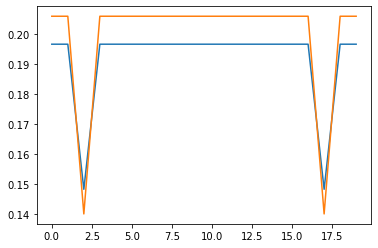

In [10]:
plt.plot(train_history)
plt.plot(val_history)

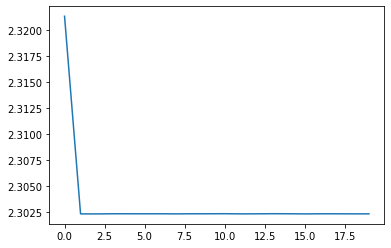

In [11]:
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.275985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.347515, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302624, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234316, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.353994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.217454, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.378711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256101, Train acc

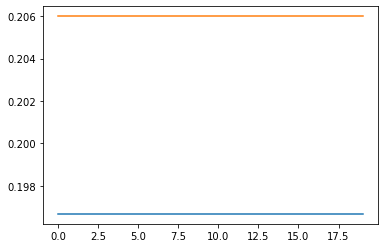

In [13]:
plt.plot(train_history)
plt.plot(val_history)

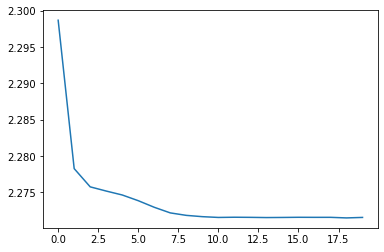

In [14]:
plt.plot(loss_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [15]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.322051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308033, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317549, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270323, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308261, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264990, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267083, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279901, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276510, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314133, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256404, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295822, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278750, Train acc

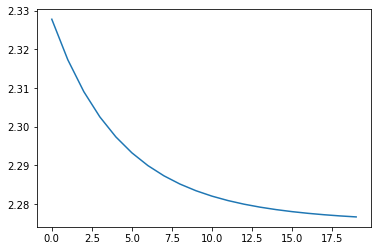

In [16]:
plt.plot(loss_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [17]:
data_size = 15
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295926, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.345443, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326544, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.199259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.164561, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.025661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.263931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.662918, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.245522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.943906, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.663953, Train acc

Loss: 1.212850, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.196541, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.280346, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.403204, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229377, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.400568, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.391042, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.102808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.219193, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.449330, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.304464, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.494726, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.327706, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.361608, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [18]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=0.09, num_epochs=20, batch_size=5, learning_rate_decay=0.99)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.297543, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.276527, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.134834, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.192671, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.108647, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.817352, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.204943, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.330577, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 2.123697, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.807521, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.474602, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.815985, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.940197, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.294772, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.220643, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.059508, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [19]:
from itertools import product

In [29]:
# Let's train the best one-hidden-layer network we can

learning_rates = np.logspace(-8, -1, num=5)
reg_strengths = np.logspace(-8, -1, num=5)
learning_rate_decays = [0.7, 0.8, 0.95, 0.99] 
hidden_layer_sizes = [128]
num_epochs_list = [10]
batch_sizes = [64]
momentums = [0.1, 0.2, 0.3]

params_list = [learning_rates, reg_strengths, learning_rate_decays, 
               hidden_layer_sizes, num_epochs_list, batch_sizes, momentums]

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X[:data_size], train_y[:data_size], 
                      val_X[:data_size], val_y[:data_size])

for params in product(*params_list):
    rate, reg, decay, size, n_epochs, batch_size, momentum = params
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=size, reg=reg)
    trainer = Trainer(model=model, dataset=dataset, optim=MomentumSGD(momentum=momentum), 
                      num_epochs=n_epochs, batch_size=batch_size, learning_rate=rate)
    loss_hist, train_hist, val_hist = trainer.fit()
    if best_val_accuracy is None or val_hist[-1] > best_val_accuracy:
        best_val_accuracy = val_hist[-1]
        best_classifier = model
        loss_history = loss_hist
        train_history = train_hist
        val_history = val_hist
        best_params = params

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302675, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302702, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302702, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302702, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302702, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302702, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302702, Train acc

Loss: 2.302639, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302609, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302495, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302495, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302495, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302495, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302495, Train acc

Loss: 2.302246, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302610, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302610, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302610, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302610, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302610, Train acc

Loss: 2.303328, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303328, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303328, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303328, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303328, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303299, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303530, Train acc

Loss: 2.341757, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.341757, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.341757, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.341757, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.341757, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.341757, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.342000, Train acc

Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302498, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302496, Train acc

Loss: 2.302368, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302367, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302366, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302366, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302366, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302366, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302366, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302366, Train acc

Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302707, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302707, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302707, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302707, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302707, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302707, Train acc

Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303282, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.341965, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.341965, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.341965, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.341965, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.341965, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.341965, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.341964, Train acc

Loss: 2.342173, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302452, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302451, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302448, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302445, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302441, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302436, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302430, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302424, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302417, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302409, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302888, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302886, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302884, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302881, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302876, Train acc

Loss: 2.302421, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302438, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302437, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302434, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302431, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302427, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302422, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302416, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302409, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302402, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302395, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302591, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302590, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302588, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302584, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302580, Train acc

Loss: 2.302843, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302841, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302839, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302836, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302832, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302827, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302821, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302814, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302807, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302800, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302680, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302679, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302676, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302673, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302669, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302664, Train acc

Loss: 2.303618, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303617, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303614, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303611, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303607, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303602, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303596, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303590, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303583, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303575, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303446, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.303445, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.303443, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.303439, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.303435, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.303430, Train acc

Loss: 2.341873, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341869, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341863, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341856, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341848, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341839, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341829, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341818, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.341998, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341997, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341993, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341989, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341983, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341976, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341968, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341959, Train acc

Loss: 2.300077, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299658, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302521, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302451, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302319, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302132, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301893, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301610, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301286, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300925, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300532, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300111, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302933, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302864, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302732, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302545, Train acc

Loss: 2.302564, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302433, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302246, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302009, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301726, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301404, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301045, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300655, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300235, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302428, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302359, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302228, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302042, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301805, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301524, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301202, Train acc

Loss: 2.301098, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300707, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300287, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303493, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303424, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303292, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303104, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302866, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302583, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302260, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301900, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301508, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301086, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303144, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303075, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302944, Train acc

Loss: 2.340851, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.340400, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.339899, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.339355, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.338772, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.342421, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.342323, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.342137, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.341873, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.341539, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.341142, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.340689, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.340187, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.339641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.339057, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.342040, Train acc

Loss: 2.302479, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298612, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291402, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.281373, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.268954, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.254348, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.237294, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.216604, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.189247, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.148797, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302855, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298982, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.291775, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.281780, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.269447, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.255043, Train acc

Loss: 2.302806, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.298932, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.291716, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.281693, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.269301, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.254765, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.237874, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.217519, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.190829, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.151788, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302957, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299097, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.291910, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.281941, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.269667, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.255386, Train acc

Loss: 2.143211, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302639, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298778, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.291589, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.281608, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.269287, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.254886, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.238268, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.218463, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.192876, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.155917, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302252, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298402, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291233, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.281280, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.269008, Train acc

Loss: 2.282302, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.270049, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255774, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.239385, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.220009, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.195226, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.159756, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.303162, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299296, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.292111, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.282149, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.269869, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.255525, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.238958, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.219155, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.193436, Train acc

Loss: 2.341721, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.336328, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.326637, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.313955, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.299554, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.284448, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.269118, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.253135, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.234527, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.208792, Train accuracy: 0.266667, val accuracy: 0.000000
best validation accuracy achieved: 0.266667


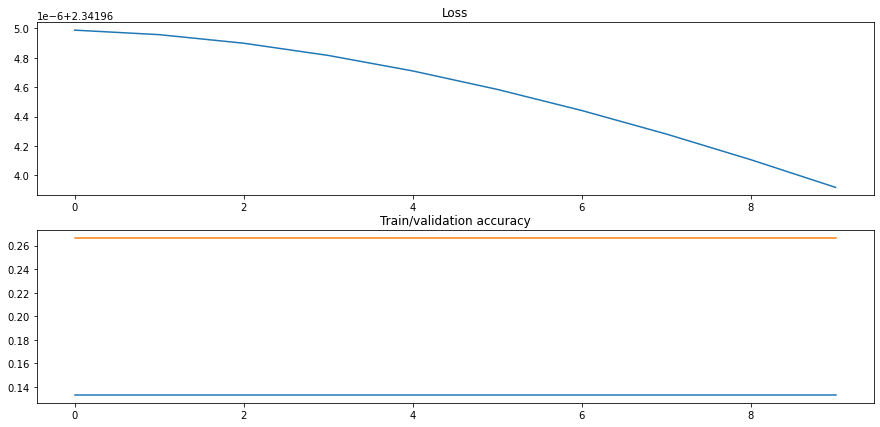

In [30]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))